Booking Completion Rates:
 booking_complete
0    0.85044
1    0.14956
Name: proportion, dtype: float64
Top 10 Routes:
 route
AKLKUL    2680
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
ICNSYD     695
DMKPER     679
DPSICN     666
DMKOOL     655
MELPEN     649
Name: count, dtype: int64


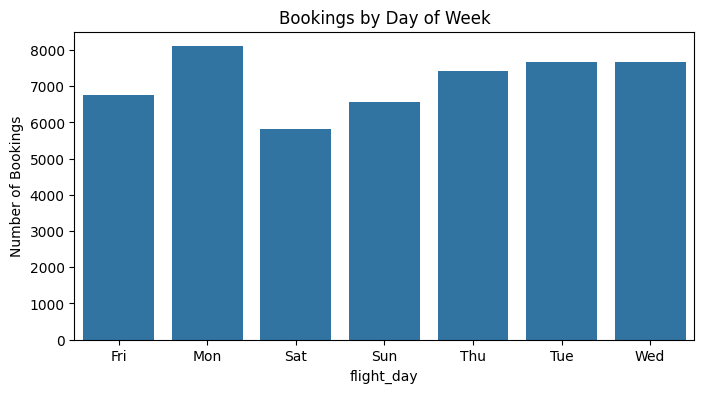

Preferences by Route:
         wants_extra_baggage  wants_preferred_seat  wants_in_flight_meals
route                                                                   
AKLDEL             0.600000              0.200000               0.550000
AKLHGH             0.000000              0.000000               0.000000
AKLHND             0.500000              0.000000               0.500000
AKLICN             0.728571              0.185714               0.542857
AKLKIX             0.500000              0.125000               0.250000
...                     ...                   ...                    ...
TRZWUH             1.000000              0.384615               1.000000
TRZXIY             0.833333              0.000000               0.666667
TWUWUH             1.000000              0.000000               0.000000
TWUXIY             0.571429              0.285714               0.285714
URTXIY             1.000000              0.000000               0.000000

[799 rows x 3 columns]


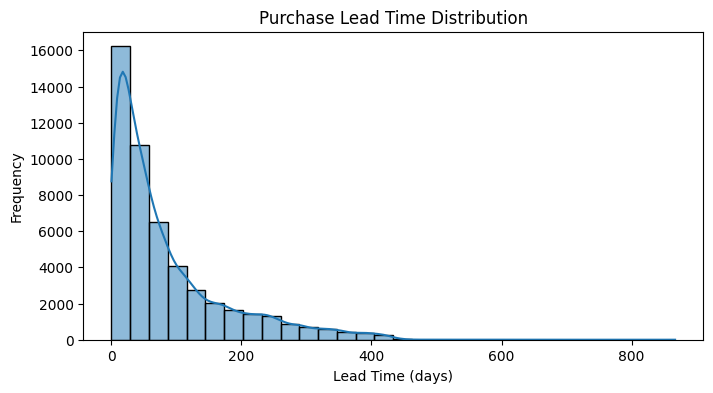

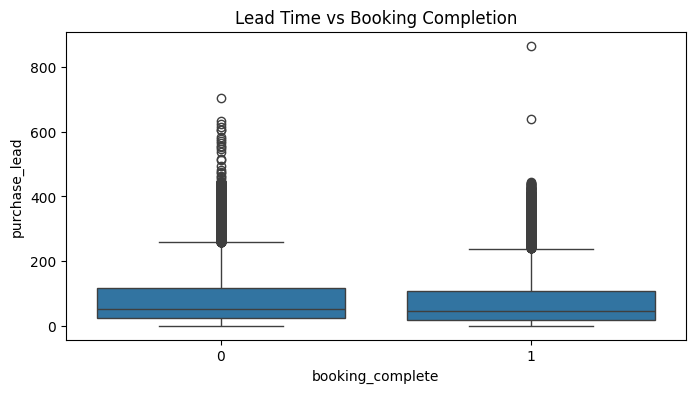

Booking success by channel and region:
 sales_channel  route_region
Internet       Other           0.154770
Mobile         Other           0.108402
Name: booking_complete, dtype: float64


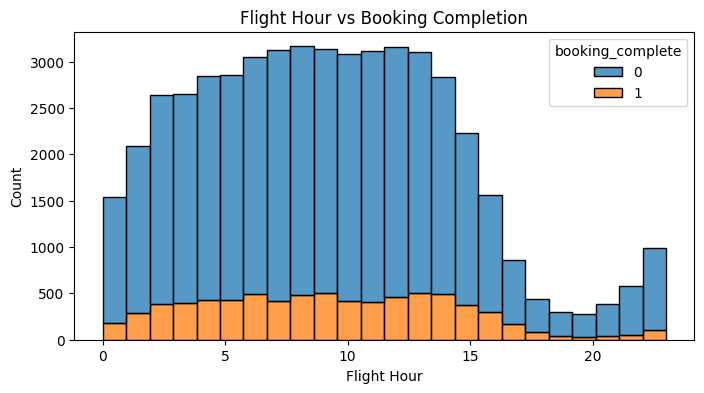

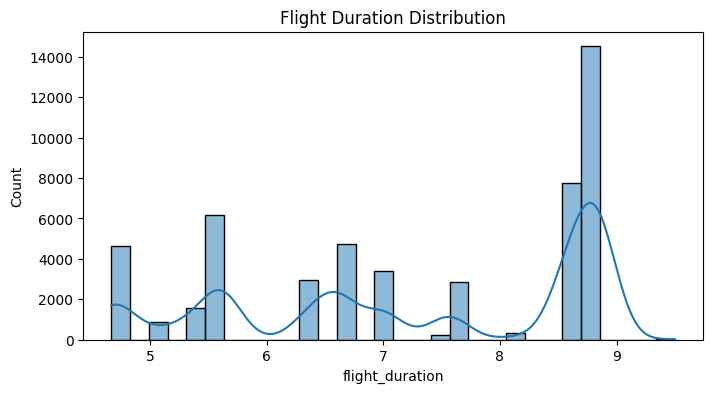

Cross-validated ROC-AUC scores: [0.68344216 0.43696539 0.28258702 0.32597097 0.72627839]
Mean ROC-AUC: 0.491


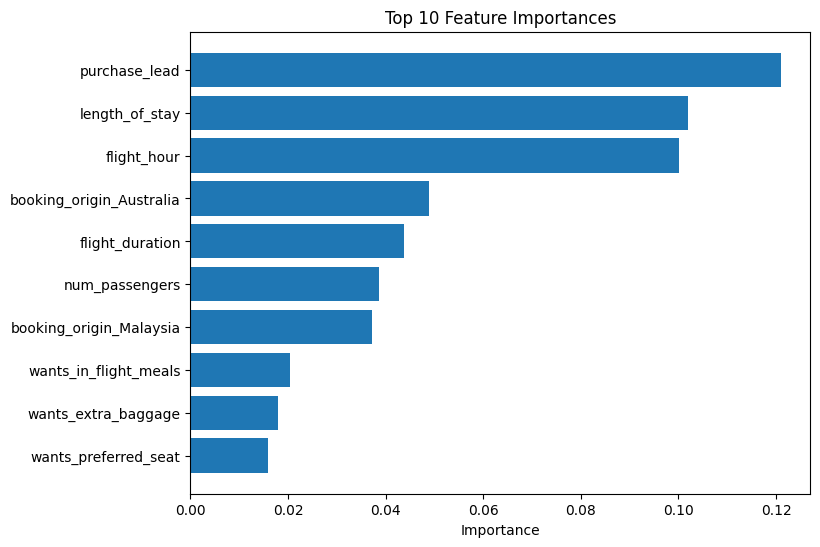

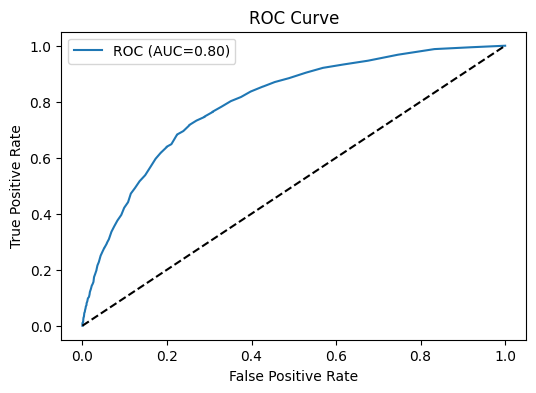

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
df = pd.read_csv('customer_booking.csv', encoding='latin1')


completion_rate = df['booking_complete'].value_counts(normalize=True)
print('Booking Completion Rates:\n', completion_rate)

route_counts = df['route'].value_counts()
top_routes = route_counts.head(10)
print('Top 10 Routes:\n', top_routes)

flight_day_counts = df['flight_day'].value_counts().sort_index()
plt.figure(figsize=(8,4))
sns.barplot(x=flight_day_counts.index, y=flight_day_counts.values)
plt.title('Bookings by Day of Week')
plt.ylabel('Number of Bookings')
plt.show()

#Customer behaviour
prefs_by_route = df.groupby('route')[['wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']].mean()
print('Preferences by Route:\n', prefs_by_route)
plt.figure(figsize=(8,4))
sns.histplot(df['purchase_lead'], bins=30, kde=True)
plt.title('Purchase Lead Time Distribution')
plt.xlabel('Lead Time (days)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x='booking_complete', y='purchase_lead', data=df)
plt.title('Lead Time vs Booking Completion')
plt.show()

#Customer segmentation
def route_region(route):
    if 'NZ' in route:
        return 'NZ'
    elif 'India' in route:
        return 'India'
    else:
        return 'Other'

df['route_region'] = df['route'].apply(route_region)
segment_counts = df.groupby(['sales_channel', 'route_region'])['booking_complete'].mean()
print('Booking success by channel and region:\n', segment_counts)

#Flight Timing & Duration
plt.figure(figsize=(8,4))
sns.histplot(data=df, x='flight_hour', hue='booking_complete', bins=24, multiple='stack')
plt.title('Flight Hour vs Booking Completion')
plt.xlabel('Flight Hour')
plt.show()

#Flight duration distribution
plt.figure(figsize=(8,4))
sns.histplot(df['flight_duration'], bins=30, kde=True)
plt.title('Flight Duration Distribution')
plt.show()

df_model = df.copy()
for col in ['sales_channel', 'trip_type', 'route', 'booking_origin', 'route_region', 'flight_day']:
    df_model[col] = df_model[col].astype('category')
df_model = pd.get_dummies(df_model, columns=['sales_channel', 'trip_type', 'route', 'booking_origin', 'route_region', 'flight_day'])

X = df_model.drop('booking_complete', axis=1)
y = df_model['booking_complete']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

cv_scores = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')
print(f'Cross-validated ROC-AUC scores: {cv_scores}')
print(f'Mean ROC-AUC: {np.mean(cv_scores):.3f}')

importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]
plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.show()

probas = rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, probas)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='ROC (AUC=%.2f)' % roc_auc_score(y_test, probas))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
n_samples = 500

data = {
    'num_passengers': np.random.choice([1, 2, 3, 4], size=n_samples, p=[0.6, 0.25, 0.1, 0.05]),
    'sales_channel': np.random.choice(['Internet', 'Mobile'], size=n_samples, p=[0.9, 0.1]),
    'trip_type': np.random.choice(['RoundTrip', 'OneWay'], size=n_samples, p=[0.99, 0.01]),
    'purchase_lead': np.clip(np.random.normal(86, 91, n_samples).astype(int), 0, 516),
    'length_of_stay': np.clip(np.random.gamma(1.5, 15, n_samples).astype(int), 0, 100),
    'flight_hour': np.random.randint(0, 24, n_samples),
    'flight_day': np.random.choice(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], size=n_samples),
    'flight_duration': np.clip(np.random.normal(7.29, 1.48, n_samples), 4.67, 9.5),
    'wants_extra_baggage': np.random.choice([0, 1], size=n_samples, p=[0.33, 0.67]),
    'wants_preferred_seat': np.random.choice([0, 1], size=n_samples, p=[0.7, 0.3]),
    'wants_in_flight_meals': np.random.choice([0, 1], size=n_samples, p=[0.58, 0.42]),
    'booking_complete': np.random.choice([0, 1], size=n_samples, p=[0.85, 0.15])
}

routes = ['AKLKUL', 'KIXSIN', 'DMKOOL', 'HNDKTM', 'ICNSIN', 'SINBKK', 'NRTSIN', 'KULSGN', 'BKKSIN', 'HKGSIN'] * 10
origins = ['Australia', 'Japan', 'Thailand', 'Singapore', 'Malaysia', 'China', 'South Korea', 'Philippines', 'Indonesia', 'Vietnam'] * 10

data['route'] = np.random.choice(routes[:50], size=n_samples)
data['booking_origin'] = np.random.choice(origins[:20], size=n_samples)
df = pd.DataFrame(data)

print("=== BOOKING COMPLETION RATES AND CONVERSION ANALYSIS ===")
completion_rate = df['booking_complete'].mean()
print(f"Overall conversion rate: {completion_rate:.3f} ({completion_rate*100:.1f}%)")

channel_conversion = df.groupby('sales_channel')['booking_complete'].agg(['count', 'sum', 'mean']).round(3)
channel_conversion.columns = ['Total_Attempts', 'Completed', 'Conversion_Rate']
print("Conversion by Sales Channel:")
print(channel_conversion)

df['lead_time_bucket'] = pd.cut(df['purchase_lead'],
                               bins=[0, 7, 30, 90, 180, 516],
                               labels=['0-7 days', '8-30 days', '31-90 days', '91-180 days', '180+ days'])

lead_conversion = df.groupby('lead_time_bucket')['booking_complete'].agg(['count', 'sum', 'mean']).round(3)
lead_conversion.columns = ['Total_Attempts', 'Completed', 'Conversion_Rate']
print("Conversion by Purchase Lead Time:")
print(lead_conversion)

=== BOOKING COMPLETION RATES AND CONVERSION ANALYSIS ===
Overall conversion rate: 0.148 (14.8%)
Conversion by Sales Channel:
               Total_Attempts  Completed  Conversion_Rate
sales_channel                                            
Internet                  455         70            0.154
Mobile                     45          4            0.089
Conversion by Purchase Lead Time:
                  Total_Attempts  Completed  Conversion_Rate
lead_time_bucket                                            
0-7 days                       7          0            0.000
8-30 days                     45          7            0.156
31-90 days                   117         20            0.171
91-180 days                  164         24            0.146
180+ days                     84         11            0.131


In [12]:
print("=== ROUTE POPULARITY AND PERFORMANCE METRICS ===")
route_metrics = df.groupby('route').agg({
    'booking_complete': ['count', 'sum', 'mean'],
    'flight_duration': 'mean',
    'num_passengers': 'mean'
}).round(3)

route_metrics.columns = ['Total_Bookings', 'Completed_Bookings', 'Conversion_Rate',
                        'Avg_Flight_Duration', 'Avg_Passengers']
route_metrics_sorted = route_metrics.sort_values('Total_Bookings', ascending=False)

print("Top 10 Most Popular Routes:")
print(route_metrics_sorted.head(10))
df['duration_category'] = pd.cut(df['flight_duration'],
                                bins=[0, 6, 7, 8, 10],
                                labels=['Short (4.7-6h)', 'Medium (6-7h)', 'Long (7-8h)', 'Very Long (8h+)'])

duration_performance = df.groupby('duration_category')['booking_complete'].agg(['count', 'sum', 'mean']).round(3)
duration_performance.columns = ['Total_Attempts', 'Completed', 'Conversion_Rate']
print("Route Performance by Flight Duration:")
print(duration_performance)
print(f"Route Analysis Summary:")
print(f"- Total unique routes: {df['route'].nunique()}")
print(f"- Average bookings per route: {df.groupby('route').size().mean():.1f}")
print(f"- Routes with >10 bookings: {(df.groupby('route').size() > 10).sum()}")

=== ROUTE POPULARITY AND PERFORMANCE METRICS ===
Top 10 Most Popular Routes:
        Total_Bookings  Completed_Bookings  Conversion_Rate  \
route                                                         
AKLKUL              64                  14            0.219   
KIXSIN              59                  10            0.169   
HKGSIN              56                   9            0.161   
SINBKK              52                   5            0.096   
KULSGN              49                   5            0.102   
DMKOOL              49                   7            0.143   
BKKSIN              48                   8            0.167   
HNDKTM              46                   5            0.109   
NRTSIN              39                   6            0.154   
ICNSIN              38                   5            0.132   

        Avg_Flight_Duration  Avg_Passengers  
route                                        
AKLKUL                7.359           1.672  
KIXSIN                7.249 

In [13]:
print("=== CUSTOMER SEGMENTATION AND BEHAVIOR PATTERNS ===")

features_for_clustering = ['num_passengers', 'purchase_lead', 'length_of_stay',
                          'flight_duration', 'wants_extra_baggage',
                          'wants_preferred_seat', 'wants_in_flight_meals']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features_for_clustering])
kmeans = KMeans(n_clusters=4, random_state=42)
df['customer_segment'] = kmeans.fit_predict(scaled_features)

segment_analysis = df.groupby('customer_segment').agg({
    'num_passengers': 'mean',
    'purchase_lead': 'mean',
    'length_of_stay': 'mean',
    'flight_duration': 'mean',
    'wants_extra_baggage': 'mean',
    'wants_preferred_seat': 'mean',
    'wants_in_flight_meals': 'mean',
    'booking_complete': ['count', 'mean']
}).round(3)

segment_analysis.columns = ['Avg_Passengers', 'Avg_Lead_Time', 'Avg_Stay_Length',
                           'Avg_Flight_Duration', 'Extra_Baggage_Rate',
                           'Preferred_Seat_Rate', 'Meals_Rate',
                           'Segment_Size', 'Conversion_Rate']

print("Customer Segments Analysis:")
print(segment_analysis)

origin_behavior = df.groupby('booking_origin').agg({
    'booking_complete': ['count', 'sum', 'mean'],
    'num_passengers': 'mean',
    'purchase_lead': 'mean',
    'wants_extra_baggage': 'mean'
}).round(3)

origin_behavior.columns = ['Total_Bookings', 'Completed', 'Conversion_Rate',
                          'Avg_Passengers', 'Avg_Lead_Time', 'Baggage_Rate']
print("Customer Behavior by Booking Origin:")
print(origin_behavior.sort_values('Total_Bookings', ascending=False).head(8))

=== CUSTOMER SEGMENTATION AND BEHAVIOR PATTERNS ===
Customer Segments Analysis:
                  Avg_Passengers  Avg_Lead_Time  Avg_Stay_Length  \
customer_segment                                                   
0                          1.296         92.837           20.800   
1                          1.298         93.649           23.238   
2                          1.298        104.132           20.579   
3                          3.361        109.373           22.940   

                  Avg_Flight_Duration  Extra_Baggage_Rate  \
customer_segment                                            
0                               7.239                0.00   
1                               7.136                1.00   
2                               7.182                1.00   
3                               7.284                0.59   

                  Preferred_Seat_Rate  Meals_Rate  Segment_Size  \
customer_segment                                                  
0         

In [14]:
print("=== ADD-ON SERVICE UPTAKE ANALYSIS ===")
baggage_rate = df['wants_extra_baggage'].mean()
seat_rate = df['wants_preferred_seat'].mean()
meal_rate = df['wants_in_flight_meals'].mean()

print(f"Overall Add-on Service Uptake:")
print(f"- Extra Baggage: {baggage_rate:.3f} ({baggage_rate*100:.1f}%)")
print(f"- Preferred Seats: {seat_rate:.3f} ({seat_rate*100:.1f}%)")
print(f"- In-flight Meals: {meal_rate:.3f} ({meal_rate*100:.1f}%)")

df['total_addons'] = df['wants_extra_baggage'] + df['wants_preferred_seat'] + df['wants_in_flight_meals']

def get_addon_combo(row):
    combo = []
    if row['wants_extra_baggage']:
        combo.append('B')
    if row['wants_preferred_seat']:
        combo.append('S')
    if row['wants_in_flight_meals']:
        combo.append('M')
    return '-'.join(combo) if combo else 'None'

df['addon_combination'] = df.apply(get_addon_combo, axis=1)

combo_analysis = df.groupby('addon_combination')['booking_complete'].agg(['count', 'sum', 'mean']).round(3)
combo_analysis.columns = ['Count', 'Completed', 'Conversion_Rate']
print("Add-on Combinations Analysis:")
print(combo_analysis.sort_values('Count', ascending=False))

print("Impact of Add-ons on Conversion:")
for addon in ['wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']:
    addon_impact = df.groupby(addon)['booking_complete'].agg(['count', 'mean']).round(3)
    addon_impact.columns = ['Count', 'Conversion_Rate']
    print(f"{addon.replace('wants_', '').replace('_', ' ').title()}:")
    print(addon_impact)

=== ADD-ON SERVICE UPTAKE ANALYSIS ===
Overall Add-on Service Uptake:
- Extra Baggage: 0.662 (66.2%)
- Preferred Seats: 0.286 (28.6%)
- In-flight Meals: 0.422 (42.2%)
Add-on Combinations Analysis:
                   Count  Completed  Conversion_Rate
addon_combination                                   
B                    136         25            0.184
B-M                  108         14            0.130
None                  63         10            0.159
B-S                   61          5            0.082
M                     50          7            0.140
S                     29          7            0.241
S-M                   27          3            0.111
B-S-M                 26          3            0.115
Impact of Add-ons on Conversion:
Extra Baggage:
                     Count  Conversion_Rate
wants_extra_baggage                        
0                      169            0.160
1                      331            0.142
Preferred Seat:
                      Count  Conv

In [15]:
print("=== SEASONAL OR TEMPORAL BOOKING TRENDS ===")
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
day_performance = df.groupby('flight_day')['booking_complete'].agg(['count', 'sum', 'mean']).round(3)
day_performance.columns = ['Total_Bookings', 'Completed', 'Conversion_Rate']
day_performance = day_performance.reindex(day_order)
print("Booking Performance by Day of Week:")
print(day_performance)

def get_time_period(hour):
    if 0 <= hour < 6:
        return 'Early Morning (0-5)'
    elif 6 <= hour < 12:
        return 'Morning (6-11)'
    elif 12 <= hour < 18:
        return 'Afternoon (12-17)'
    else:
        return 'Evening (18-23)'

df['time_period'] = df['flight_hour'].apply(get_time_period)
time_performance = df.groupby('time_period')['booking_complete'].agg(['count', 'sum', 'mean']).round(3)
time_performance.columns = ['Total_Bookings', 'Completed', 'Conversion_Rate']
print("Booking Performance by Time Period:")
print(time_performance)

lead_addon_correlation = df[['purchase_lead', 'wants_extra_baggage', 'wants_preferred_seat',
                            'wants_in_flight_meals', 'booking_complete']].corr().round(3)
print("Lead Time Correlations:")
print(lead_addon_correlation['purchase_lead'])

=== SEASONAL OR TEMPORAL BOOKING TRENDS ===
Booking Performance by Day of Week:
            Total_Bookings  Completed  Conversion_Rate
flight_day                                            
Mon                     70          5            0.071
Tue                     71         10            0.141
Wed                     71         15            0.211
Thu                     67         10            0.149
Fri                     71         11            0.155
Sat                     73         11            0.151
Sun                     77         12            0.156
Booking Performance by Time Period:
                     Total_Bookings  Completed  Conversion_Rate
time_period                                                    
Afternoon (12-17)               136         25            0.184
Early Morning (0-5)             108         21            0.194
Evening (18-23)                 131         14            0.107
Morning (6-11)                  125         14            0.112
Lead 

In [16]:
print("=== GEOGRAPHIC BOOKING PATTERNS ===")

geo_performance = df.groupby('booking_origin').agg({
    'booking_complete': ['count', 'sum', 'mean'],
    'num_passengers': 'mean',
    'purchase_lead': 'mean',
    'flight_duration': 'mean',
    'wants_extra_baggage': 'mean',
    'total_addons': 'mean'
}).round(3)

geo_performance.columns = ['Total_Bookings', 'Completed', 'Conversion_Rate',
                          'Avg_Passengers', 'Avg_Lead_Time', 'Avg_Duration',
                          'Baggage_Rate', 'Avg_Addons']

print("Geographic Performance Analysis:")
print(geo_performance.sort_values('Total_Bookings', ascending=False))

route_origin_combo = df.groupby(['route', 'booking_origin']).agg({
    'booking_complete': ['count', 'sum', 'mean']
}).round(3)
route_origin_combo.columns = ['Total_Bookings', 'Completed', 'Conversion_Rate']

print("Top Route-Origin Combinations (min 3 bookings):")
top_combos = route_origin_combo[route_origin_combo['Total_Bookings'] >= 3]
print(top_combos.sort_values('Total_Bookings', ascending=False).head(10))

channel_geo = pd.crosstab(df['booking_origin'], df['sales_channel'], normalize='index').round(3)
print("Sales Channel Preference by Geography:")
print(channel_geo.head(10))
print("Market Analysis:")
print(f"- Geographic diversity index: {1 - (geo_performance['Total_Bookings']/len(df)).pow(2).sum():.3f}")
print(f"- Top 3 origins: {geo_performance.sort_values('Total_Bookings', ascending=False).head(3)['Total_Bookings'].sum()/len(df)*100:.1f}% of bookings")

=== GEOGRAPHIC BOOKING PATTERNS ===
Geographic Performance Analysis:
                Total_Bookings  Completed  Conversion_Rate  Avg_Passengers  \
booking_origin                                                               
Malaysia                    58          7            0.121           1.500   
Indonesia                   55         10            0.182           1.691   
Australia                   53         10            0.189           1.623   
Vietnam                     51          8            0.157           1.745   
Thailand                    51          8            0.157           1.431   
South Korea                 51         10            0.196           1.686   
Singapore                   50          4            0.080           1.640   
China                       47          4            0.085           1.723   
Philippines                 42          7            0.167           1.690   
Japan                       42          6            0.143           1.71

In [18]:
print("=== REVENUE OPTIMIZATION INSIGHTS ===")

base_fare = 500
extra_baggage_fee = 50
preferred_seat_fee = 30
meal_fee = 25

df['base_revenue'] = df['num_passengers'] * base_fare
df['addon_revenue'] = (df['wants_extra_baggage'] * extra_baggage_fee +
                       df['wants_preferred_seat'] * preferred_seat_fee +
                       df['wants_in_flight_meals'] * meal_fee)
df['total_potential_revenue'] = df['base_revenue'] + df['addon_revenue']
df['actual_revenue'] = df['total_potential_revenue'] * df['booking_complete']

print("Revenue Analysis:")
print(f"Total Potential Revenue: ${df['total_potential_revenue'].sum():,.2f}")
print(f"Total Actual Revenue: ${df['actual_revenue'].sum():,.2f}")
print(f"Revenue Loss: ${(df['total_potential_revenue'] - df['actual_revenue']).sum():,.2f}")
print(f"Revenue Capture Rate: {df['actual_revenue'].sum() / df['total_potential_revenue'].sum():.1%}")

segment_revenue = df.groupby('customer_segment').agg({
    'actual_revenue': ['sum', 'mean'],
    'total_potential_revenue': ['sum', 'mean'],
    'booking_complete': 'mean'
}).round(2)

segment_revenue.columns = ['Total_Revenue', 'Avg_Revenue_per_Customer',
                          'Total_Potential', 'Avg_Potential_per_Customer', 'Conversion_Rate']
print("Revenue by Customer Segment:")
print(segment_revenue)
high_value_threshold = df['total_potential_revenue'].quantile(0.75)
df['is_high_value'] = df['total_potential_revenue'] >= high_value_threshold

high_value_analysis = df.groupby('is_high_value').agg({
    'booking_complete': ['count', 'sum', 'mean'],
    'total_potential_revenue': 'mean',
    'actual_revenue': 'mean'
}).round(3)

print("High-Value vs Standard Customer Analysis:")
print(high_value_analysis)

=== REVENUE OPTIMIZATION INSIGHTS ===
Revenue Analysis:
Total Potential Revenue: $436,115.00
Total Actual Revenue: $59,065.00
Revenue Loss: $377,050.00
Revenue Capture Rate: 13.5%
Revenue by Customer Segment:
                  Total_Revenue  Avg_Revenue_per_Customer  Total_Potential  \
customer_segment                                                             
0                         13940                    103.26            90285   
1                         17950                    106.85           119020   
2                         11365                     99.69            83090   
3                         15810                    190.48           143720   

                  Avg_Potential_per_Customer  Conversion_Rate  
customer_segment                                               
0                                     668.78             0.16  
1                                     708.45             0.15  
2                                     728.86             0.15  
3 